In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df = pd.read_csv("healthcare_dataset.csv")
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [ ]:
#Standardize column names & text
df.columns = df.columns.str.lower().str.replace(' ', '_')

#Fix inconsistent name casing
df["name"] = df["name"].str.title()
df["doctor"] = df["doctor"].str.title()
df["hospital"] = df["hospital"].str.title()

In [ ]:
#Convert Date columns
df["date_of_admission"] = pd.to_datetime(df["date_of_admission"])
df["discharge_date"] = pd.to_datetime(df["discharge_date"])

In [ ]:
#Create Length of Stay feature
df["length_of_stay"] = (df["discharge_date"] - df["date_of_admission"]).dt.days

In [ ]:
#Checking for missing values
df.isna().sum()

,0
name,0
age,0
gender,0
blood_type,0
medical_condition,0
date_of_admission,0
doctor,0
hospital,0
insurance_provider,0
billing_amount,0


In [ ]:
#Rounding Billing Amount column to 2 decimal places
df["billing_amount"] = df["billing_amount"].round(2)

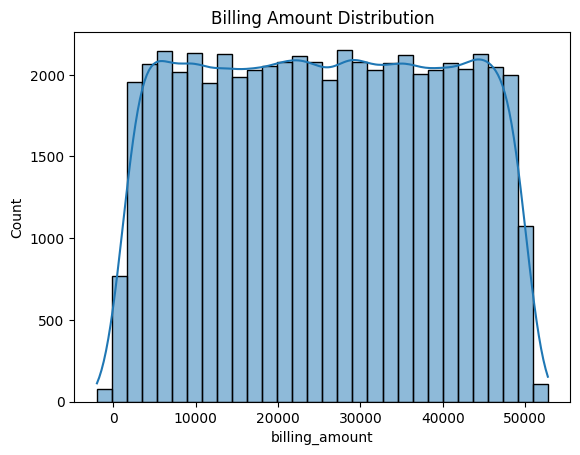

In [ ]:
#Distribution of Billing Amount
plt.figure()
sns.histplot(df["billing_amount"], bins=30, kde=True)
plt.title("Billing Amount Distribution")
plt.show()

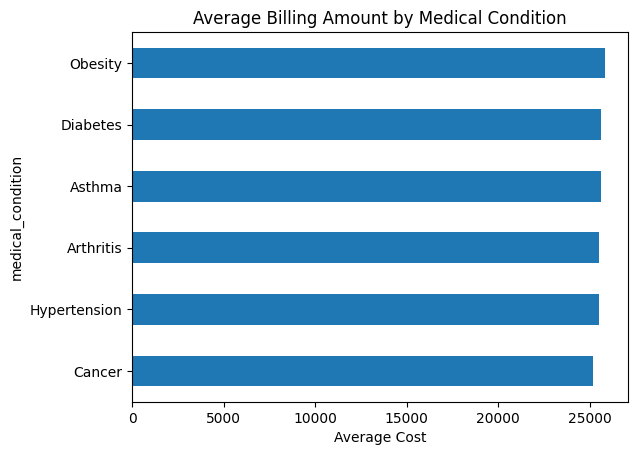

In [ ]:
#Average billing by medical condition
condition_cost = df.groupby("medical_condition")["billing_amount"].mean().sort_values()

plt.figure()
condition_cost.plot(kind="barh")
plt.title("Average Billing Amount by Medical Condition")
plt.xlabel("Average Cost")
plt.show()

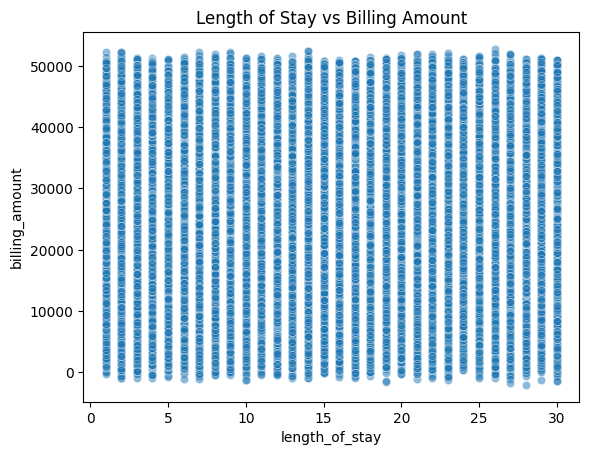

In [ ]:
#Length of stay vs billing amount
plt.figure()
sns.scatterplot(
    data=df,
    x="length_of_stay",
    y="billing_amount",
    alpha=0.5
)
plt.title("Length of Stay vs Billing Amount")
plt.show()

In [ ]:
#Predicting billing amount
X = df[
    [
        "age",
        "gender",
        "medical_condition",
        "insurance_provider",
        "admission_type",
        "length_of_stay"
    ]
]

y = df["billing_amount"]

In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
#Encoding + Model Pipeline
categorical_features = [
    "gender",
    "medical_condition",
    "insurance_provider",
    "admission_type"
]

numeric_features = [
    "age",
    "length_of_stay"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ]
)

In [ ]:
#Train Model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender',
                                                   'medical_condition',
                                                   'insurance_provider',
                                                   'admission_type']),
                                                 ('num', 'passthrough',
                                                  ['age', 'length_of_stay'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [ ]:
#Model Evaluation
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", round(mae, 2))
print("R² Score:", round(r2, 3))

Mean Absolute Error: 12468.41
R² Score: -0.106


In [ ]:
#Feature Importance (Interpretation)
feature_names = (
    pipeline.named_steps["preprocessor"]
    .get_feature_names_out()
)

importances = pipeline.named_steps["model"].feature_importances_

feature_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance_df.head(10)

,feature,importance
16,num__age,0.305956
17,num__length_of_stay,0.250061
14,cat__admission_type_Emergency,0.032098
13,cat__admission_type_Elective,0.031957
15,cat__admission_type_Urgent,0.031088
10,cat__insurance_provider_Cigna,0.030710
1,cat__gender_Male,0.030163
0,cat__gender_Female,0.029880
12,cat__insurance_provider_UnitedHealthcare,0.029856
9,cat__insurance_provider_Blue Cross,0.029583


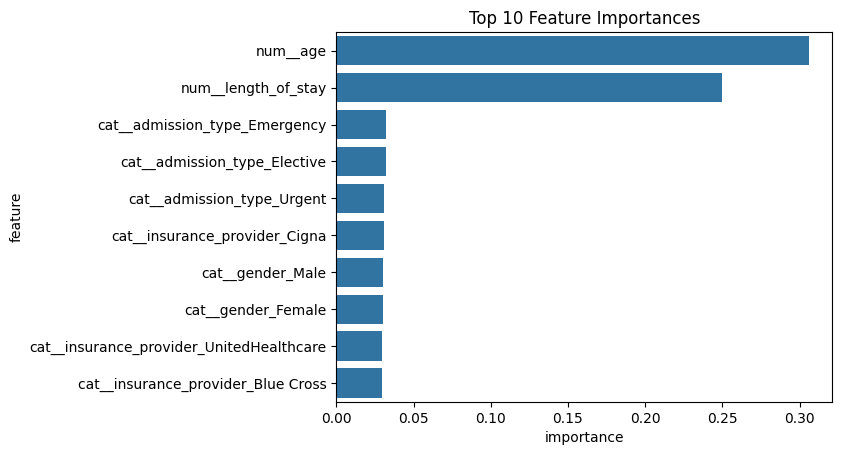

In [ ]:
plt.figure()
sns.barplot(
    data=feature_importance_df.head(10),
    x="importance",
    y="feature"
)
plt.title("Top 10 Feature Importances")
plt.show()

In [ ]:
#Prediction Example
new_patient = pd.DataFrame({
    "age": [55],
    "gender": ["Male"],
    "medical_condition": ["Diabetes"],
    "insurance_provider": ["Medicare"],
    "admission_type": ["Emergency"],
    "length_of_stay": [6]
})

predicted_cost = pipeline.predict(new_patient)
print("Predicted Billing Amount:", round(predicted_cost[0], 2))

Predicted Billing Amount: 29020.05


In [ ]:
#Saving data
df.to_csv('Healthcare_data_analysis', index=False)